In [ ]:
!pip install gmft==0.0.2 -q

In [ ]:
!pip show gmft

Name: gmft
Version: 0.0.2
Summary: Lightweight, performant, configurable, deep table extraction
Home-page: 
Author: conjunct
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: pandas, pillow, pypdfium2, timm, transformers
Required-by: 


In [ ]:
# get the PubTables-1M paper, source of original Table Transformer (TATR)
!mkdir ./samples
!wget -O ./samples/tatr.pdf -q https://arxiv.org/pdf/2110.00061
!wget -O ./samples/attention.pdf -q https://arxiv.org/pdf/1706.03762
!wget -O ./samples/nmr.pdf -q http://ccc.chem.pitt.edu/wipf/Web/NMR_Impurities.pdf

## tatr.pdf, attention.pdf, and nmr.pdf

In [ ]:
import importlib
import gmft
import gmft.table_detection
import gmft.table_visualization
import gmft.table_function
import gmft.pdf_bindings
import gmft.common

importlib.reload(gmft)
importlib.reload(gmft.common)
importlib.reload(gmft.table_detection)
importlib.reload(gmft.table_visualization)
importlib.reload(gmft.table_function)
importlib.reload(gmft.pdf_bindings)

In [1]:
import gmft

from gmft.pdf_bindings import PyPDFium2Document
from gmft import CroppedTable, TableDetector

detector = TableDetector()

from gmft import TATRTableFormatter

formatter = TATRTableFormatter()

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        tables += detector.extract(page)
    return tables, doc


/home/conjunct/.virtualenvs/Enzy/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/conjunct/.virtualenvs/Enzy/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/conjunct/.virtualenvs/Enzy/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._

In [2]:
import time
_total_detect_time = 0
_total_detect_num = 0
_total_format_time = 0
_total_format_num = 0

results = []
images = []
dfs = []
for paper in ['tatr.pdf', 'attention.pdf', 'nmr.pdf']:
  start = time.time()
  tables, doc = ingest_pdf('./samples/' + paper)
  num_pages = len(doc)
  end_detect = time.time()
  formatted_tables = []
  for table in tables:
    ft = formatter.extract(table)
    try:
      dfs.append(ft.df())
    except Exception as e:
      print(e)
      dfs.append(None)
    formatted_tables.append(ft)
    # cache images, because closing document will prevent image access
    images.append(ft.image())
  end_format = time.time()


  doc.close()
  results += formatted_tables
  print(f"Paper: {paper}\nDetect time: {end_detect - start:.3f}s for {num_pages} pages")
  print(f"Format time: {end_format - end_detect:.3f}s for {len(tables)} tables\n")
  _total_detect_time += end_detect - start
  _total_detect_num += num_pages
  _total_format_time += end_format - end_detect
  _total_format_num += len(tables)
print(f"Macro: {_total_detect_time/_total_detect_num:.3f} s/page and {_total_format_time/_total_format_num:.3f} s/table ")

Paper: tatr.pdf
Detect time: 5.286s for 10 pages
Format time: 1.957s for 6 tables

Paper: attention.pdf
Detect time: 14.940s for 15 pages
Format time: 1.909s for 5 tables

The identified boxes have significant overlap: 37.25% of area is overlapping (Max is 20.00%)
Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.
Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.
Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.
Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.
Paper: nmr.pdf
Detect time: 4.027s for 9 pages
Format time: 2.529s for 5 tables

Macro: 0.713 s/page and 0.400 s/table 


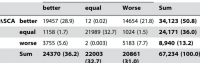

Empty DataFrame
Columns: [, , , , , ]
Index: []

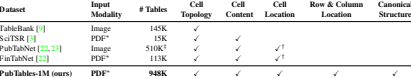

Dataset Input Modality # Tables Cell Topology Cell Content  \
0        TableBank [9]          Image     145K             X                
1           SciTSR [3]           PDF∗      15K             X            X   
2   PubTabNet [22, 23]          Image    510K‡             X            X   
3       FinTabNet [22]           PDF∗     113K             X            X   
4  PubTables-1M (ours)           PDF∗     948K             X            X   

  Cell Location Row & Column Location Canonical Structure  
0                                                          
1                                                          
2            X†                                            
3            X†                                            
4             X                     X                   X

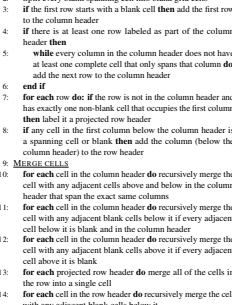

is_spanning_row
0      2:  Split every blank spanning cell into blank gri...            False
1      3:  if the first row starts with a blank cell then...            False
2      4:  if there is at least one row labeled as part o...            False
3   5: 6:  while every column in the column header does n...            False
4      7:  for each row do: if the row is not in the colu...            False
5      8:  has exactly one non-blank cell that occupies t...            False
6      9:       column header) to the row header MERGE CELLS            False
7     10:  for each cell in the column header do recursiv...             True
8          cell with any adjacent cells above and below i...            False
9     11:  header that span the exact same columns for ea...            False
10    12:  for each cell in the column header do recursiv...            False
11    13:  for each projected row header do merge all of ...            False
12    14:  for each cell in the row header do recursively...            False

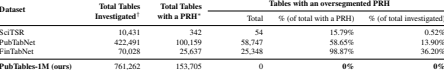

Dataset Total Tables Investigated† Total Tables with a PRH∗  \
0               SciTSR                     10,431                      342   
1            PubTabNet                    422,491                  100,159   
2            FinTabNet                     70,028                   25,637   
3  PubTables-1M (ours)                    761,262                  153,705   

    Total Tables with an oversegmented % (of total with a PRH)  \
0      54                                             15.79%     
1  58,747                                             58.65%     
2  25,348                                             98.87%     
3       0                                                 0%     

  PRH % (of total investigated)  
0                         0.52%  
1                        13.90%  
2                        36.20%  
3                            0%

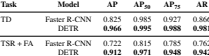

Task         Model     AP   AP50   AP75     AR
0        TD  Faster R-CNN  0.825  0.985  0.927  0.866
1                    DETR  0.966  0.995  0.988  0.981
2  TSR + FA  Faster R-CNN  0.722  0.815  0.785  0.762
3                    DETR  0.912  0.971  0.948  0.942

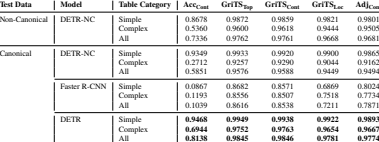

Test Data         Model Table Category AccCont GriTSTop GriTSCont  \
0   Non-Canonical       DETR-NC         Simple  0.8678   0.9872    0.9859   
1                                      Complex  0.5360   0.9600    0.9618   
2                                          All  0.7336   0.9762    0.9761   
3       Canonical       DETR-NC         Simple  0.9349   0.9933    0.9920   
4                                      Complex  0.2712   0.9257    0.9290   
5                                          All  0.5851   0.9576    0.9588   
6                  Faster R-CNN         Simple  0.0867   0.8682    0.8571   
7                                      Complex  0.1193   0.8556    0.8507   
8                                          All  0.1039   0.8616    0.8538   
9                          DETR         Simple  0.9468   0.9949    0.9938   
10                                     Complex  0.6944   0.9752    0.9763   
11                                         All  0.8138   0.9845    0.9846   

   GriTSLoc AdjCont  
0    0.9821  0.9801  
1    0.9444  0.9505  
2    0.9668  0.9681  
3    0.9900  0.9865  
4    0.9044  0.9162  
5    0.9449  0.9494  
6    0.6869  0.8024  
7    0.7518  0.7734  
8    0.7211  0.7871  
9    0.9922  0.9893  
10   0.9654  0.9667  
11   0.9781  0.9774

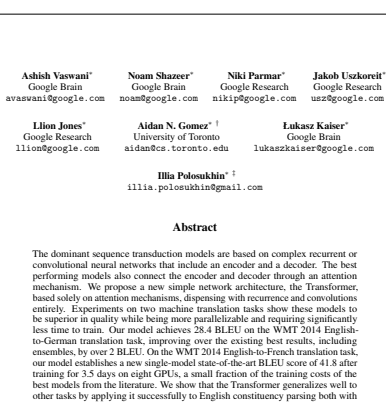

Ashish Vaswani∗ Google Brain avaswani@google.com  \
0                                                      
1                                              Llion   
2            Jones∗ Google Research llion@google.com   
3                                                      
4                                                      
5                                                      
6                                                      
7                              The dominant sequence   
8  convolutional neural performing models mechani...   
9                                                      

          Noam Shazeer∗ Google Brain noam@google.com  \
0                                                      
1                                           Aidan N.   
2                 University of aidan@cs.toronto.edu   
3                                              Illia   
4                         illia.polosukhin@gmail.com   
5                                                      
6                                                      
7                                       transduction   
8  networks that include also connect the propose...   
9                                     training data.   

                                                      \
0                                                      
1                                           Gomez∗ †   
2                                            Toronto   
3                                        Polosukhin∗   
4                                                      
5                                                      
6                                           Abstract   
7                                         models are   
8  an encoder and network dispensing translation ...   
9                                                      

       Niki Parmar∗ Google Research nikip@google.com  \
0                                                      
1                                             Łukasz   
2                                                      
3                                                      
4                                                      
5                                                      
6                                                      
7                                   based on complex   
8  encoder and a decoder through architecture, th...   
9                                                      

     Jakob Uszkoreit∗ Google Research usz@google.com  is_spanning_row  
0                                                                True  
1                                            Kaiser∗            False  
2               Google Brain lukaszkaiser@google.com            False  
3                                                               False  
4                                                               False  
5                                                                True  
6                                                               False  
7                                       recurrent or             True  
8  decoder. The best an attention Transformer, co...            False  
9                                                                True

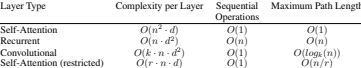

Layer Type Complexity per Layer Sequential Operations  \
0               Self-Attention           O(n 2 · d)                  O(1)   
1                    Recurrent          O(n · d 2 )                  O(n)   
2                Convolutional      O(k · n · d 2 )                  O(1)   
3  Self-Attention (restricted)         O(r · n · d)                  O(1)   

  Maximum Path Length  
0                O(1)  
1                O(n)  
2          O(logk(n))  
3              O(n/r)

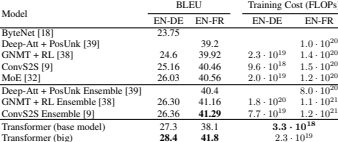

Model  EN-DE BLEU EN-FR Training EN-DE  \
1                      ByteNet [18]  23.75                             
2            Deep-Att + PosUnk [39]              39.2                  
3                    GNMT + RL [38]   24.6      39.92     2.3 · 1019   
4                       ConvS2S [9]  25.16      40.46     9.6 · 1018   
5                          MoE [32]  26.03      40.56     2.0 · 1019   
6   Deep-Att + PosUnk Ensemble [39]              40.4                  
7           GNMT + RL Ensemble [38]  26.30      41.16     1.8 · 1020   
8              ConvS2S Ensemble [9]  26.36      41.29     7.7 · 1019   
9          Transformer (base model)   27.3       38.1          3.3 ·   
10                Transformer (big)   28.4       41.8          2.3 ·   

   Cost (FLOPs) EN-FR  
1                      
2          1.0 · 1020  
3          1.4 · 1020  
4          1.5 · 1020  
5          1.2 · 1020  
6          8.0 · 1020  
7          1.1 · 1021  
8          1.2 · 1021  
9                1018  
10               1019

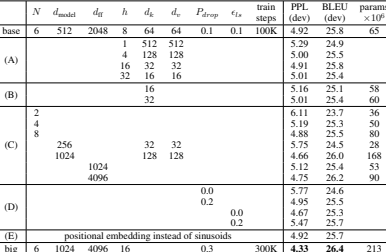

N dmodel         dff          h   dk          dv      Pdrop  ϵls  \
0   base  6    512        2048          8   64          64        0.1  0.1   
1                                       1  512         512                   
2                                       4  128         128                   
3    (A)                               16   32          32                   
4                                      32   16          16                   
5                                           16                               
6    (B)                                    32                               
7         2                                                                  
8         4                                                                  
9         8                                                                  
10   (C)       256                          32          32                   
11            1024                         128         128                   
12                        1024                                               
13                        4096                                               
14                                                                0.0        
15                                                                0.2        
16   (D)                                                               0.0   
17                                                                     0.2   
18   (E)            positional  embedding       instead of  sinusoids        
19   big  6   1024        4096         16                         0.3        

   train steps PPL (dev) BLEU (dev) params ×106  
0         100K      4.92       25.8          65  
1                   5.29       24.9              
2                   5.00       25.5              
3                   4.91       25.8              
4                   5.01       25.4              
5                   5.16       25.1          58  
6                   5.01       25.4          60  
7                   6.11       23.7          36  
8                   5.19       25.3          50  
9                   4.88       25.5          80  
10                  5.75       24.5          28  
11                  4.66       26.0         168  
12                  5.12       25.4          53  
13                  4.75       26.2          90  
14                  5.77       24.6              
15                  4.95       25.5              
16                  4.67       25.3              
17                  5.47       25.7              
18                  4.92       25.7              
19        300K      4.33       26.4         213

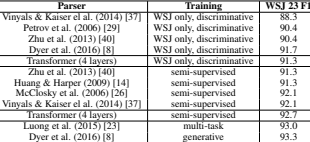

Parser                  Training WSJ 23 F1
0   Vinyals & Kaiser el al. (2014) [37]  WSJ only, discriminative      88.3
1             Petrov et al. (2006) [29]  WSJ only, discriminative      90.4
2                Zhu et al. (2013) [40]  WSJ only, discriminative      90.4
3                Dyer et al. (2016) [8]  WSJ only, discriminative      91.7
4                Transformer (4 layers)  WSJ only, discriminative      91.3
5                Zhu et al. (2013) [40]           semi-supervised      91.3
6            Huang & Harper (2009) [14]           semi-supervised      91.3
7           McClosky et al. (2006) [26]           semi-supervised      92.1
8   Vinyals & Kaiser el al. (2014) [37]           semi-supervised      92.1
9                Transformer (4 layers)           semi-supervised      92.7
10             Luong et al. (2015) [23]                multi-task      93.0
11               Dyer et al. (2016) [8]                generative      93.3

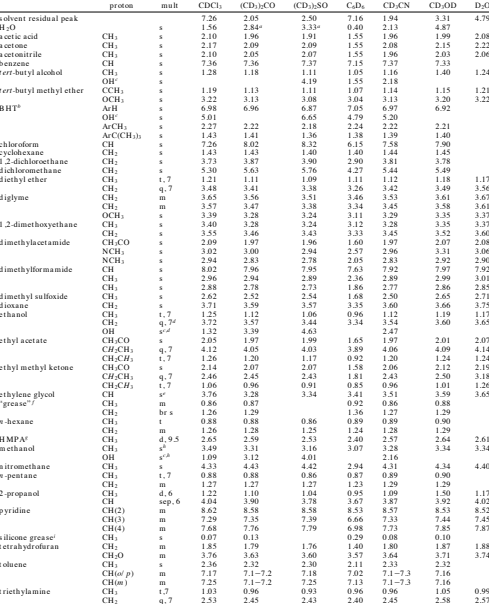

pr ot on   m ult CDCl3 (CD3)2CO (CD3)2SO  \
1               solvent esidu al k                     7.26     2.05     2.50   
2                            r pea                                              
3                              H2O                  s  1.56    2.84a    3.33a   
5                    a cetic a cid        CH3       s  2.10     1.96     1.91   
7                       a cet on e        CH3       s  2.17     2.09     2.09   
8                  a cet onit rile        CH3       s  2.10     2.05     2.07   
10                         benzene         CH       s  7.36     7.36     7.37   
12            tert-but yl alcoh ol        CH3       s  1.28     1.18     1.11   
13                                        OHc                            4.19   
14                                                  s                           
15   tert-but yl m et h yl et h er       CCH3       s  1.19     1.13     1.11   
17                                       OCH3       s  3.22     3.13     3.08   
18                            BHTb        ArH                            6.87   
19                                                  s  6.98     6.96            
20                                        OHc       s  5.01              6.65   
22                                      ArCH3       s  2.27     2.22     2.18   
24                                  ArC(CH3)3       s  1.43     1.41     1.36   
25                     chlor oform         CH          7.26     8.02     8.32   
26                                                  s                           
27                  cycloh exa n e        CH2       s  1.43     1.43     1.40   
29         1,2-dichlor oet h a n e        CH2       s  3.73     3.87     3.90   
30                       dichlor h                     5.30     5.63     5.76   
31                     om et a n e        CH2       s                           
32                   diethyl ether        CH3    t, 7  1.21     1.11     1.09   
34                                        CH2    q, 7  3.48     3.41     3.38   
36                         diglyme        CH2       m  3.65     3.56     3.51   
37                                        CH2          3.57     3.47     3.38   
38                                                  m                           
39                                       OCH3       s  3.39     3.28     3.24   
41      1,2-dim et h oxyet h a n e        CH3       s  3.40     3.28     3.24   
42                                                     3.55     3.46     3.43   
43                                        CH2       s                           
44          dim et h yla cet amide      CH3CO       s  2.09     1.97     1.96   
46                                       NCH3       s  3.02     3.00     2.94   
48                                       NCH3       s  2.94     2.83     2.78   
49           dim et h ylform amide         CH       s  8.02     7.96     7.95   
51                                        CH3       s  2.96     2.94     2.89   
53                                        CH3       s  2.88     2.78     2.73   
54                 dim h sulfoxide                     2.62     2.52     2.54   
55                           et yl        CH3       s                           
56                       dioxa n e        CH2       s  3.71     3.59     3.57   
58                     et h a n ol        CH3    t, 7  1.25     1.12     1.06   
60                                        CH2   q, 7d  3.72     3.57     3.44   
61                                         OH    sc,d  1.32     3.39     4.63   
63              et h yl a cet at e      CH3CO       s  2.05     1.97     1.99   
65                                     CH2CH3    q, 7  4.12     4.05     4.03   
66                                                  7  1.26     1.20     1.17   
67                                     CH2CH3      t,                           
68      et h yl m et h yl ket on e      CH3CO       s  2.14     2.07

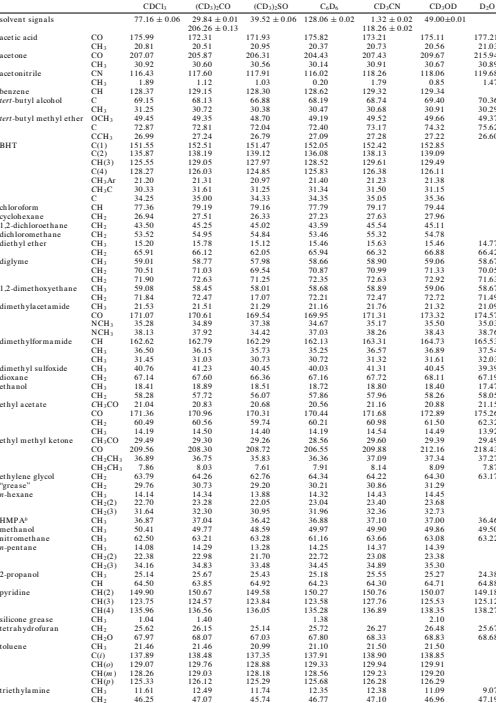

CDCl3       (CD3)2CO (CD3)2SO  \
1              solvent sign als          77.16 ( 0.06   29.84 ( 0.01  39.52 (   
2                                                      206.26 ( 0.13            
4                 a cetic a cid      CO        175.99         172.31   171.93   
6                                   CH3         20.81          20.51    20.95   
7                           cet      CO        207.07         205.87   206.31   
8                        a on e                                                 
9                                   CH3         30.92          30.60    30.56   
11              a cet onit rile      CN        116.43         117.60   117.91   
12                                                                              
13                                  CH3          1.89           1.12     1.03   
14                      benzene      CH        128.37         129.15   128.30   
16         tert-but yl alcoh ol       C         69.15          68.13    66.88   
18                                  CH3         31.25          30.72    30.38   
19           tert-but et h et h    OCH3         49.45          49.35    48.70   
20                   yl m yl er                                                 
21                                    C         72.87          72.81    72.04   
23                                 CCH3         26.99          27.24    26.79   
24                          BHT                151.55         152.51   151.47   
25                                 C(1)                                         
26                                 C(2)        135.87         138.19   139.12   
28                               CH (3)        125.55         129.05   127.97   
30                                 C(4)        128.27         126.03   124.85   
31                                CH3Ar         21.20          21.31    20.97   
33                                 CH3C         30.33          31.61    31.25   
35                                    C         34.25          35.00    34.33   
36                  chlor oform      CH         77.36          79.19    79.16   
38               cycloh exa n e     CH2         26.94          27.51    26.33   
40      1,2-dichlor oet h a n e     CH2         43.50          45.25    45.02   
42        dichlor om et h a n e     CH2         53.52          54.95    54.84   
43                diethyl ether     CH3         15.20          15.78    15.12   
45                                  CH2         65.91          66.12    62.05   
47                      diglyme     CH3         59.01          58.77    57.98   
48                                              70.51          71.03    69.54   
49                                  CH2                                         
50                                  CH2         71.90          72.63    71.25   
52   1,2-dim et h oxyet h a n e     CH3         59.08          58.45    58.01   
54                                  CH2         71.84          72.47    17.07   
55       dim et h yla cet amide     CH3         21.53          21.51    21.29   
57                                   CO        171.07         170.61   169.54   
59                                 NCH3         35.28          34.89    37.38   
60                                              38.13          37.92    34.42   
61                                 NCH3                                         
62        dim et h ylform amide      CH        162.62         162.79   162.29   
64                                  CH3         36.50          36.15    35.73   
66                                  CH3         31.45          31.03    30.73   
67        dim et h yl sulfoxide     CH3         40.76          41.23    40.45   
69                    dioxa n e     CH2         67.14          67.60    66.36   
71                  et h a n ol     CH3         18.41          18.89    18.51   
72                                              58.28          57.72    56.07  

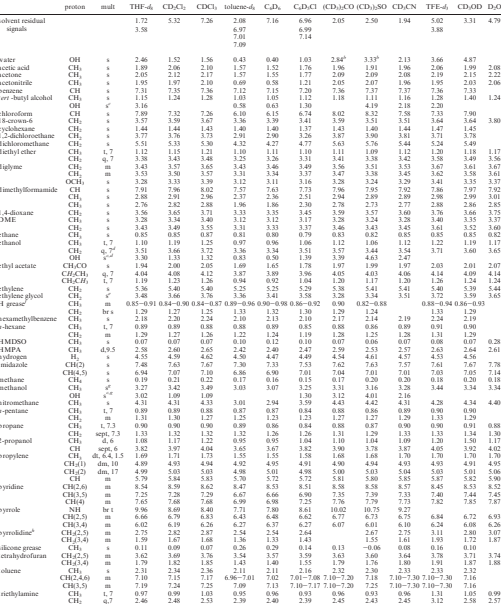

proton          mult     THF-d8     CD2Cl2  \
2       solvent residual                                1.72       5.32   
4                signals                                3.58              
5                                                                         
7                                                                         
10                 water         OH             s       2.46       1.52   
12           acetic acid        CH3             s       1.89       2.06   
13               acetone                                2.05       2.12   
14                              CH3             s                         
15          acetonitrile        CH3             s       1.95       1.97   
17               benzene         CH             s       7.31       7.35   
18   tert -butyl alcohol        CH3             s       1.15       1.24   
20                               OH            sc       3.16              
22            chloroform         CH             s       7.89       7.32   
23            18-crown-6        CH2             s       3.57       3.59   
25           cyclohexane        CH2             s       1.44       1.44   
26                                                      3.77       3.76   
27    1,2-dichloroethane        CH2             s                         
28       dichloromethane        CH2             s       5.51       5.33   
30         diethyl ether        CH3          t, 7       1.12       1.15   
31                                              7       3.38       3.43   
32                              CH2            q,                         
33               diglyme        CH2             m       3.43       3.57   
35                              CH2             m       3.53       3.50   
36                             OCH3             s       3.28       3.33   
38     dimethylformamide         CH             s       7.91       7.96   
40                              CH3             s       2.88       2.91   
41                              CH3             s       2.76       2.82   
43           1,4-dioxane        CH2             s       3.56       3.65   
44                   DME                                3.28       3.34   
45                              CH3             s                         
46                              CH2             s       3.43       3.49   
48                ethane        CH3             s       0.85       0.85   
49               ethanol                        7       1.10       1.19   
50                              CH3            t,                         
51                              CH2         q, 7d       3.51       3.66   
53                               OH          sc,d       3.30       1.33   
54         ethyl acetate      CH3CO             s       1.94       2.00   
56                           CH2CH3          q, 7       4.04       4.08   
58                           CH2CH3          t, 7       1.19       1.23   
59              ethylene        CH2             s       5.36       5.40   
60                                              e                         
61       ethylene glycol        CH2             s       3.48       3.66   
62               greasef                                                  
63                     H        CH3             m  0.85-0.91  0.84-0.90   
64                              CH2          br s       1.29       1.27   
66     hexamethylbenzene        CH3             s       2.18       2.20   
67              n-hexane                        7       0.89       0.89   
68                              CH3            t,                         
69                              CH2             m       1.29       1.27   
71                 HMDSO        CH3             s       0.07       0.07   
72                  HMPA        CH3         d,9.5       2.58       2.60   
74              hydrogen         H2             s       4.55       4.59   
76             imidazole      CH(2)             s     

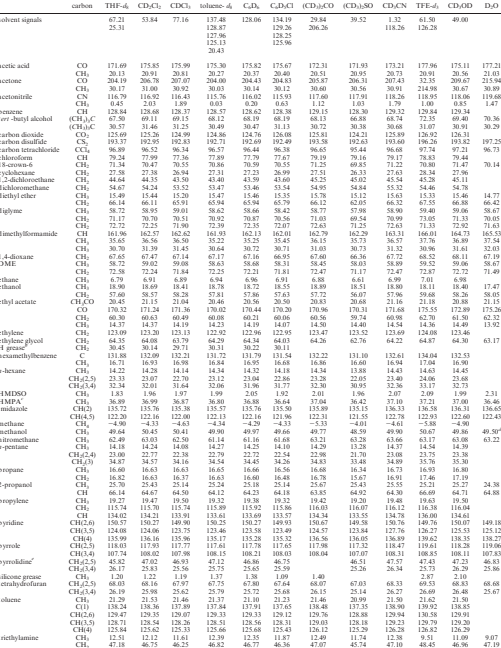

carbon  THF-d8  CD2Cl2   CDCl3 toluene- d8  \
2         solvent signals             67.21   53.84   77.16   137.48      
4                                     25.31                   128.87      
5                                                             127.96      
7                                                             125.13      
8                                                              20.43      
12            acetic acid        CO  171.69  175.85  175.99   175.30      
13                              CH3   20.13   20.91   20.81    20.27      
15                acetone        CO  204.19  206.78  207.07   204.00      
17                              CH3   30.17   31.00   30.92    30.03      
18           acetonitrile        CN  116.79  116.92  116.43   115.76      
20                              CH3    0.45    2.03    1.89     0.03      
22                benzene        CH  128.84  128.68  128.37   128.57      
23    tert -butyl alcohol   (CH3)3C   67.50   69.11   69.15    68.12      
25                          (CH3)3C   30.57   31.46   31.25    30.49      
26         carbon dioxide            125.69  125.26  124.99   124.86      
27                              CO2                                       
28       carbon disulfide       CS2  193.37  192.95  192.83   192.71      
30   carbon tetrachloride      CCl4   96.89   96.52   96.34    96.57      
31             chloroform        CH   79.24   77.99   77.36    77.89      
33             18-crown-6       CH2   71.34   70.47   70.55    70.86      
35            cyclohexane       CH2   27.58   27.38   26.94    27.31      
36     1,2-dichloroethane       CH2   44.64   44.35   43.50    43.40      
38        dichloromethane       CH2   54.67   54.24   53.52    53.47      
40          diethyl ether       CH3   15.49   15.44   15.20    15.47      
41                              CH2   66.14   66.11   65.91    65.94      
43                diglyme       CH3   58.72   58.95   59.01    58.62      
44                                    71.17   70.70   70.51    70.92      
45                              CH2                                       
46                              CH2   72.72   72.25   71.90    72.39      
48      dimethylformamide        CH  161.96  162.57  162.62   161.93      
49                                    35.65   36.56   36.50    35.22      
50                              CH3                                       
51                              CH3   30.70   31.39   31.45    30.64      
53            1,4-dioxane       CH2   67.65   67.47   67.14    67.17      
54                    DME       CH3   58.72   59.02   59.08    58.63      
56                              CH2   72.58   72.24   71.84    72.25      
58                 ethane       CH3    6.79    6.91    6.89     6.94      
59                ethanol       CH3   18.90   18.69   18.41    18.78      
61                              CH2   57.60   58.57   58.28    57.81      
62                                    20.45   21.15   21.04    20.46      
63          ethyl acetate     CH3CO                                       
64                               CO  170.32  171.24  171.36   170.02      
66                              CH2   60.30   60.63   60.49    60.08      
67                                    14.37   14.37   14.19    14.23      
68                              CH3                                       
69               ethylene       CH2  123.09  123.20  123.13   122.92      
71        ethylene glycol       CH2   64.35   64.08   63.79    64.29      
72              H greaseb       CH2   30.45   30.14   29.71    30.31      
74      hexamethylbenzene         C  131.88  132.09  132.21   131.72      
76                              CH3   16.71   16.93   16.98    16.84      
77               n-hexane       CH3   14.22   14.28   14.14    14.34      
79                         CH2(2,5)   23.33   23.07   22.70    23.12      
81                         CH2(3,4)   32.34   32.01   

In [3]:
from IPython.display import display
import pandas as pd

for df, img in zip(dfs, images):
  display(img)
  with pd.option_context('display.max_rows', 500):
    if df is not None:
      display(df.fillna(""))

Task         Model     AP   AP50   AP75     AR
0        TD  Faster R-CNN  0.825  0.985  0.927  0.866
1      None          DETR  0.966  0.995  0.988  0.981
2  TSR + FA  Faster R-CNN  0.722  0.815  0.785  0.762
3      None          DETR  0.912  0.971  0.948  0.942

## bulk extract subset

We will be downloading a bunch of articles to demonstrate bulk extraction. They are all open access articles with permissive licenses. We will be using them unmodified. Please see sources in the below table.



| doi                                  | Title                                                                                                                                                     | Author        | Notes                                           | Url                                                                       | License                                                     |
|--------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|-------------------------------------------------|---------------------------------------------------------------------------|-------------------------------------------------------------|
| 10.1007/s13201-023-02046-6           | Synthesis of a nanocomposite with holocellulose extracted from barley straw and montmorillonite, and optimization of the removal of methylene blue dye using the synthesized adsorbent | Farzi et al.  |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf)  | CC BY 4.0   |
| 10.1007/s40268-021-00343-6           | Population Pharmacokinetic Model of N-acetylmannosamine (ManNAc) and N-acetylneuraminic acid (Neu5Ac) in Subjects with GNE Myopathy                          | Wart et al.   |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf)  | CC BY 4.0   |
| 10.1038/s41467-023-38544-z           | Approaching enzymatic catalysis with zeolites or how to select one reaction mechanism competing with others                                                | Ferri et al.  | alternating table style                        | [Link](https://www.nature.com/articles/s41467-023-38544-z.pdf)               | CC BY 4.0   |
| 10.1038/srep17787                    | Deciphering Genomic Underpinnings of Quantitative MRI-based Radiomic Phenotypes of Invasive Breast Carcinoma                                               | Zhu et al.    | image table and difficult table with uneven columns | [Link](https://www.nature.com/articles/srep17787.pdf)                        | CC BY 4.0   |
| 10.1107/s2052252519008285            | Catalytically important damage-free structures of a copper nitrite reductase obtained by femtosecond X-ray laser and room-temperature neutron crystallography | Halsted et al. |                                                 | [Link](https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf)      | CC BY 4.0                                                   |
| 10.1186/s12284-023-00656-x           | The Inferior Grain Filling Initiation Promotes the Source Strength of Rice Leaves                                                                          | Jiang et al.  |                                                 | [Link](https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf) | CC BY 4.0   |
| 10.1186/1471-2334-11-124             | Core mutations, IL28B polymorphisms and response to peginterferon/ribavirin treatment in Swedish patients with hepatitis C virus genotype 1 infection      | Alestig et al.| very large table                                | [Link](https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf)    | CC BY 2.0                                                   |
| 10.48550/arXiv.2211.13344            | Solubility of water in peridotite liquids and the prevalence of steam atmospheres on rocky planets                                                         | Sossi et al.  | vertical table                                  | [Link](https://arxiv.org/pdf/2211.13344)                                        | CC BY 4.0   |


In [ ]:
!mkdir ./bulk
!wget -O bulk/1.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf
!wget -O bulk/2.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf
!wget -O bulk/3.pdf bulk -q https://www.nature.com/articles/s41467-023-38544-z.pdf
!wget -O bulk/4.pdf bulk -q https://www.nature.com/articles/srep17787.pdf
!wget -O bulk/5.pdf bulk -q https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf
!wget -O bulk/6.pdf bulk -q https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf
!wget -O bulk/7.pdf bulk -q https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf
!wget -O bulk/8.pdf bulk -q https://arxiv.org/pdf/2211.13344

In [ ]:
!mkdir results
!mkdir results/false_positives

In [ ]:
import json
import re
page_keywords_re_s = [re.compile(x, re.IGNORECASE) for x in \
                    [r'\btables?\b']]

In [ ]:
from gmft import CroppedTable, TableDetector, TATRTableFormatter
from gmft.pdf_bindings import PyPDFium2Document

detector = TableDetector()
formatter = TATRTableFormatter()

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        page_text = ""
        for text in page.get_positions_and_text():
            page_text += text[4] + " "
        if any([re.search(x, page_text) for x in page_keywords_re_s]):
            tables += detector.extract(page)
    return tables, doc


In [ ]:
import os
from tqdm import tqdm

root = "bulk"
save_dir = "results"

last_processed = None # list(os.listdir(root))[4020]

In [ ]:
for filename in tqdm(sorted(os.listdir(root))):
    if last_processed is not None and filename < last_processed:
        continue
    if filename.endswith(".pdf"):
        filename = filename[:-4]
        # check if folder exists
        if os.path.exists(f"{save_dir}/{filename}"):
            continue

        # ingest pdf
        doc = None
        try:
            tables, doc = ingest_pdf(f"{root}/{filename}.pdf")
            exists = False
            for i, table in enumerate(tables):
                # check for keywords presence again
                # text = table.text()
                # if not any([re.search(x, text) for x in table_keywords_re_s]):
                    # continue

                if table.label == 1:
                    if not exists:
                        # make folder
                        os.makedirs(f"{save_dir}/{filename}")
                        exists = True
                    table.image(dpi=144).save(f"{save_dir}/{filename}/{i}_rotated.png")
                    json.dump(table.to_dict(), open(f"{save_dir}/{filename}/{i}_rotated.info.json", "w"))
                    continue
                if not exists:
                    # make folder
                    os.makedirs(f"{save_dir}/{filename}")
                    exists = True
                try:
                    ft = formatter.extract(table)
                    # write image, csv, and info to {save_dir}/{filename}/{table_no}.{png,csv,info.json}
                    ft.image(dpi=144).save(f"{save_dir}/{filename}/{i}.png")
                    ft.df().to_csv(f"{save_dir}/{filename}/{i}.csv", index=False)
                    # this includes, for instance, outlier info
                    json.dump(ft.to_dict(), open(f"{save_dir}/{filename}/{i}.info.json", "w"))
                except Exception as e:
                    print(f"Error processing {filename}, {i}, {e}")
        except Exception as e:
            print(f"Error processing {filename}, {e}")
            continue
        finally:
            if doc is not None:
                doc.close()


        last_processed = filename

 75%|███████▌  | 6/8 [02:25<00:38, 19.16s/it]

Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.


100%|██████████| 8/8 [02:45<00:00, 20.74s/it]


(Note that filtering by keywords may speed up inference.)

Component           Company
0           Ethanol (96%)  Mojallaly (Iran)
1     Sulfuric acid (72%)         Mojallaly
2       Acetic acid (98%)             Merck
3       Nitric acid (65%)         Mojallaly
4  Sodium hydroxide (99%)             Merck
5         Montmorillonite             Merck
6          Methylene blue         Mojallaly
7              Urea (99%)             Merck

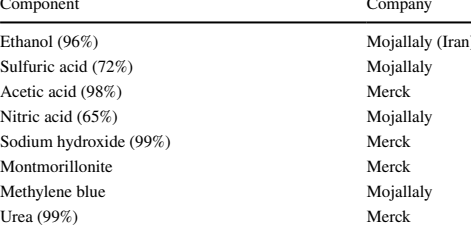

Factor Complete name Coded name Levels Range  −1    0    1
0                     Temperature (°C)         x1        25–35  25   30   35
1                                   pH         x2          4–8   4    6    8
2  Initial dye concen￾tration (mg L−1)         x3          4–8   4    6    8
3                            Mesh size         x4       50–150  50  100  150

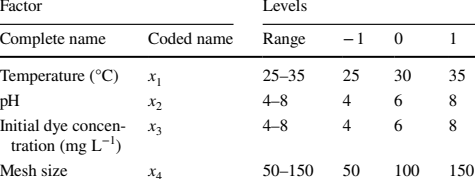

Adsorbent  Specifc surface area (m2 g−1)  Total pore vol￾ume (cm3 g−1)  \
0      HCMM                         25.147                         8.635   

   Average particle size (nm)  
0                      84.172

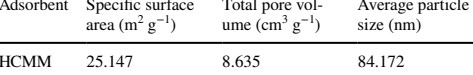

Run  x1: T (°C)  x2: pH  x3: MB initial concen￾tration (mg L−1)  \
0     1          25       8                                       4   
1     2          30       6                                       6   
2     3          30       6                                       4   
3     4          30       6                                       6   
4     5          30       6                                       6   
5     6          25       8                                       8   
6     7          30       8                                       6   
7     8          30       4                                       6   
8     9          35       8                                       4   
9    10          35       4                                       8   
10   11          30       6                                       6   
11   12          35       6                                       6   
12   13          35       8                                       4   
13   14          35       8                                       8   
14   15          25       4                                       8   
15   16          35       4                                       4   
16   17          30       6                                       6   
17   18          35       4                                       8   
18   19          25       8                                       8   
19   20          35       4                                       4   
20   21          25       6                                       6   
21   22          30       6                                       6   
22   23          35       8                                       8   
23   24          25       4                                       4   
24   25          30       6                                       8   
25   26          30       6                                       6   
26   27          25       8                                       4   
27   28          30       6                                       6   
28   29          25       4                                       4   
29   30          25       4                                       8   

    x4: Mesh size  MB removal (%)  
0             150           84.90  
1             100           89.31  
2             100           90.71  
3              50           91.09  
4             100           89.34  
5              50           87.38  
6             100           92.12  
7             100           87.16  
8              50           92.14  
9              50           85.56  
10            150           85.15  
11            100           88.86  
12            150           91.16  
13            150           87.57  
14            150           77.24  
15            150           84.04  
16            100           89.61  
17            150           80.90  
18            150           80.34  
19             50           87.16  
20            100           85.77  
21            100           89.31  
22             50           90.82  
23             50           89.43  
24            100           86.87  
25            100           89.14  
26             50           91.03  
27            100           90.14  
28            150           81.58  
29             50           85.48

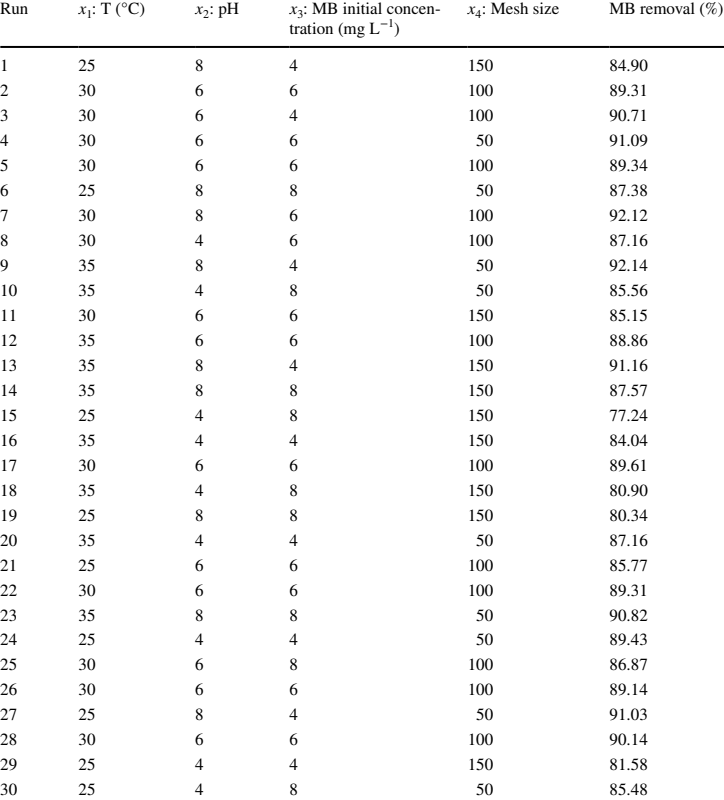

Source        DF Adjusted SS   Adj MS F value p value
0        Model        14     401.025  28.6446  218.33     0.0
1           x1         1       6.457   6.4568   49.21     0.0
2           x2         1       2.068    2.068   15.76   0.001
3           x3         1       0.014   0.0141    0.11   0.748
4           x4         1       2.209    2.209   16.84   0.001
5         x2 1         1       10.26  10.2603    78.2     0.0
6         x2 2         1       0.291   0.2908    2.22   0.157
7         x2 3         1       0.687   0.6872    5.24   0.037
8         x2 4         1       3.638   3.6382   27.73     0.0
9         x1x2         1      12.443  12.4433   94.84     0.0
10        x1x3         1       2.933   2.9327   22.35     0.0
11        x1x4         1      18.598  18.5977  141.75     0.0
12        x2x3         1       0.001   0.0005     0.0   0.951
13        x2x4         1       2.616   2.6163   19.94     0.0
14        x3x4         1       1.632    1.632   12.44   0.003
15       Error        15       1.968   0.1312                
16  Lack-of-ft        10       1.323   0.1323    1.02   0.523
17  Pure error         5       0.645   0.1291                
18       Total        29     402.993                         
19  R2= 99.51%    Adj R2                                     
20              = 99.06%

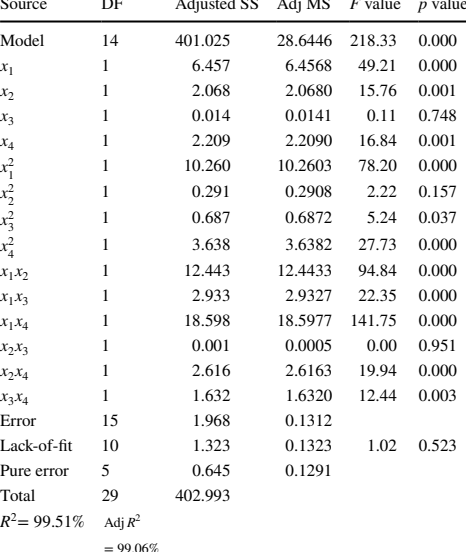

Adsorbent(s) Adsorbent dosage (g/L)  \
0                                                HCMM                      1   
1       Activated carbon from Rumex abyssinicus plant                0.2–0.6   
2   Barley straw and corn stalks modifed by citric...                   6–14   
3                    Activated carbon from Scrap Tire                    2.5   
4                   Barley Bran and Enset Midrib Leaf                    2.5   
5              Raspberry (Rubus idaeus) leaves powder                    1–5   
6            Activated carbon from grape leaves waste             0.25–12.25   
7             Activated carbon from grape wood wastes             0.25–12.25   
8                                    Black tea wastes                   13.3   
9   Carboxymethyl cellulose grafted by polyacrylic...                    100   
10     Activated carbon from Parthenium hysterophorus                     20   
11                                             Kaolin                      1   
12                                    Modifed sawdust                  1.5–5   
13                         Raw and modifed mango seed                0.1–1.2   
14            Montmorillonite modifed with iron oxide                    0.1   
15                 Activated carbon from barley straw                    0.1   
16                                            Fly ash                   8–20   

   Removal percentage                    Reference  
0         77.24–95.14                    This work  
1         82.16–99.96           Fito et al. (2023)  
2               48–97    Soldatkina & Yanar (2023)  
3         89.18–90.48       Kassahun et al. (2022)  
4               96–98        Mekuria et al. (2022)  
5               30–44       Mosoarca et al. (2022)  
6              0–97.4       Mousavi et al. (2022a)  
7             0–95.66       Mousavi et al. (2022b)  
8               30–72          Ullah et al. (2022)  
9               38–97       Hosseini et al. (2022)  
10              86–94           Fito et al. (2020)  
11              67–97          Mouni et al. (2018)  
12          34.4–96.6            Zou et al. (2013)  
13            68–99.8  Senthil Kumar et al. (2014)  
14        26.78–60.98         Cottet et al. (2014)  
15               5–70       Husseien et al. (2007)  
16           45.16–96          Kumar et al. (2005)

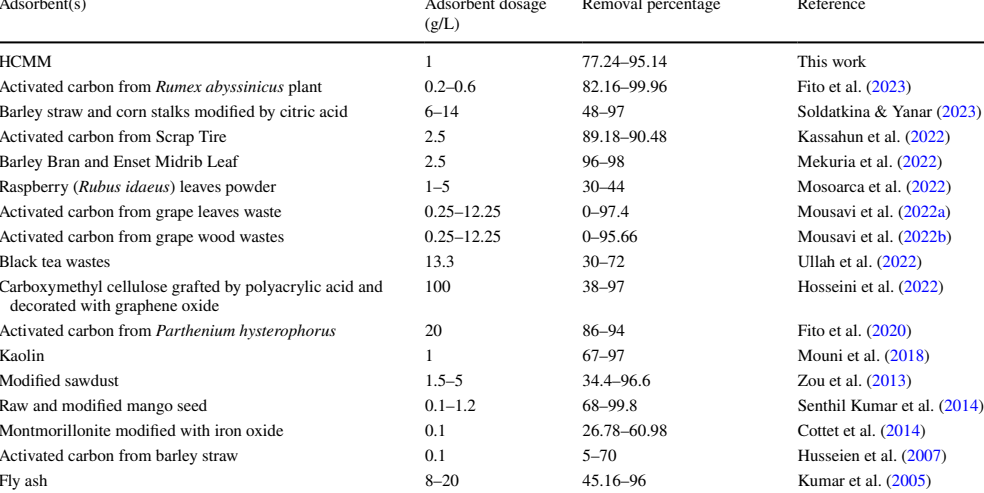

Variable  Optimum value
0              Initial concentration of dye (mg L−1)           4.00
1                                   Temperature (°C)          32.00
2                                                 pH           8.00
3                                Adsorbent mesh size          70.00
4                       Predicted removal percentage          93.91
5  Experimental removal percentage at optimal con...          95.14

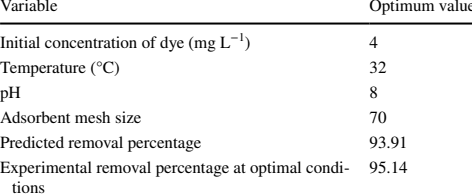

Model         Parameters Unnamed: 2
0               Langmuir         qm(mg g−1)        159
1                                kL(L mg−1)     0.0956
2                                        R2      0.984
3             Freundlich                  n       2.52
4                                kF(mg g−1)      26.42
5                                        R2      0.891
6                 Temkin                  B     29.245
7                                kT(L mg−1)      1.518
8                         b(J g mg−1 mol−1)         87
9                                        R2      0.970
10  Dubinin–Radushkevich                 kD  3.71×10−9
11                               qD(mg g−1)      420.0
12                             E (kJ mol−1)      11.60
13                                       R2      0.910

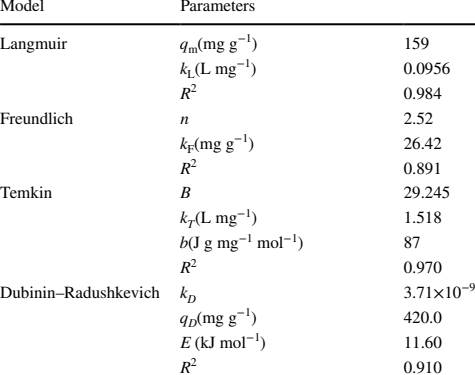

Kinetic model            Parameters  Unnamed: 2
0      Linear driving force             k1(min−1)      0.0604
1                                 qe,calc(mg g−1)     22.3900
2                                  qe,exp(mg g−1)     54.2800
3                                              R2      0.9270
4       Pseudo-second-order       qe,calc(mg g−1)     55.5700
5                                k2(g.mg−1 min−1)      0.0180
6                                              R2      0.9990
7   Intra-particle difusion  k3,1(mg g−1 min−0.5)      1.7660
8                                      I1(mg g−1)     39.3600
9                                            R2 1      0.9920
10                           k3,2(mg g−1 min−0.5)      0.1310
11                                     I2(mg g−1)     52.9600
12                                           R2 2      1.0000

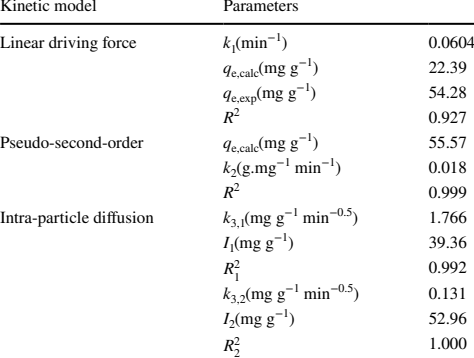

Stage of phar￾macokinetic modeling  \
0                            Stage 1   
1                            Stage 2   
2                            Stage 3   
3                            Stage 4   

                                       Data utilized  \
0  ManNAc single dose pharmacokinetic data (Study...   
1  ManNAc BID pharmacokinetic data (Study 15-HG-0...   
2  Stage 2 population pharmacokinetic model for M...   
3  All available data, including the additional T...   

                                 Modeling activities  
0  Design of structural pharmacokinetic model Exp...  
1  Covariate analysis Determination of non-linear...  
2  Monte Carlo simulations of dosing regimens Rec...  
3                     Finalize pharmacokinetic model

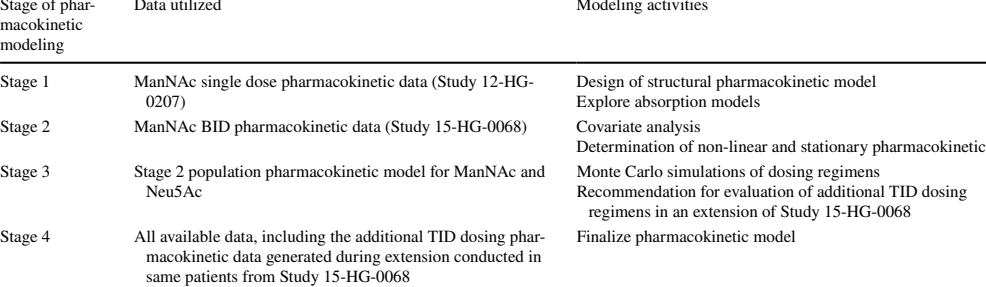

Variable      N (%)   Mean     SD Median    Min    Max  \
0                Age (years)         34   41.3   10.4   39.5   25.0   65.0   
1                Weight (kg)         34   83.5   20.2   84.6   49.3  115.0   
2                Height (cm)         34  173.0   13.3  172.0  151.0  197.0   
3               BMI (kg/m2 )         34   27.6    4.7   27.2   19.1   39.8   
4                  BSA (m2 )         34   2.01   0.31   2.06   1.45    2.5   
5             eGFR (mL/min)a         34  123.0   22.2  120.0   85.0  170.0   
6             Albumin (g/dL)         34   3.83  0.403    3.8    3.2    4.8   
7   Serum creatinine (mg/dL)         34  0.499  0.223   0.49   0.12   0.95   
8      Creatine kinase (U/L)         34  236.0  124.0  220.0   44.0  556.0   
9                        Sex                                                 
10                      Male  16 (47.1)                                      
11                    Female  18 (52.9)                                      
12                      Race                                                 
13                                                                           
14                 Caucasian  24 (70.6)                                      
15                     Asian   8 (26.5)                                      
16                     Other   2 (2.94)                                      
17      GNE domain mutations                                                 
18          Epimerase/kinase  23 (67.6)                                      
19             Kinase/kinase   8 (23.5)                                      
20           Deletion/kinase   2 (5.88)                                      
21       Epimerase/epimerase   1 (2.94)                                      

    is_spanning_row  
0             False  
1             False  
2             False  
3             False  
4             False  
5             False  
6             False  
7             False  
8             False  
9             False  
10            False  
11            False  
12            False  
13             True  
14            False  
15            False  
16            False  
17            False  
18            False  
19            False  
20            False  
21            False

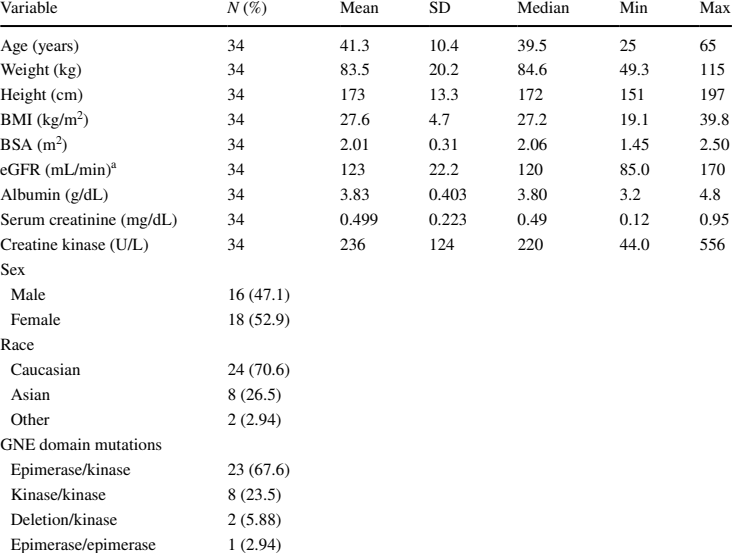

ManNAc dose Q8H for 30 Median days 5th–95th percentiles  \
0  Plasma ManNAc   Css,ave (ng/mL)                             
1            3 g               922                  501–1550   
2            4 g              1060                  573–1790   
3            6 g              1290                  692–2180   
4           10 g              1650                  883–2810   
5  Plasma Neu5Ac   Css,ave (ng/mL)                             
6            3 g               633                  247–2010   
7            4 g               702                  265–2300   
8            6 g               818                  296–2780   
9           10 g              1020                  344–3540   

  Q12H for 30 Median days 5th–95th percentiles.1 Q24H for Median  \
0                                                                  
1              642.0                    359–1060           365.0   
2              729.0                    404–1220           411.0   
3              881.0                    480–1480           483.0   
4             1120.0                    607–1900           603.0   
5                                                                  
6              484.0                    209–1420           338.0   
7              533.0                    222–1610           364.0   
8              612.0                    242–1930           405.0   
9              735.0                    274–2440           464.0   

  30 days 5th–95th percentiles  is_spanning_row  
0                                         False  
1                      223–570            False  
2                      246–650            False  
3                      281–780            False  
4                      340–989            False  
5                                          True  
6                      174–825            False  
7                      181–921            False  
8                     190–1080            False  
9                     204–1330            False

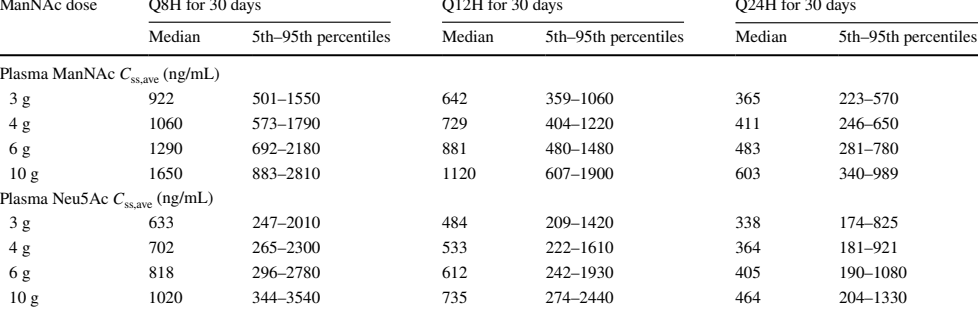

Parameter Final typical value estimate   %SEM  \
0                               ka (h−1)                        0.256   15.2   
1                            CLM/F (L/h)                          631   14.8   
2                               VM/F (L)                          506   29.4   
3                             M0 (ng/mL)                         61.1   12.0   
4                             N0 (ng/mL)                          150   5.71   
5                             kout (h−1)                        0.283   5.65   
6                         SLP0 (ng/mL)−1                     0.000619   29.1   
7                        SLPSS (ng/mL)−1                      0.00334   35.0   
8                             kinc (h−1)                       0.0287   45.3   
9                               tlag (h)                        0.254   26.4   
10                          ksyn (μg/h)a                       38,554          
11                       kpro (ng/mL·h)a                         40.9          
12  Relative ManNAc bio￾availability (F)                                       
13                                                                             
14                        F for 6 g dose                            1  Fixed   
15                          F-Dose slope                       −0.405   39.0   
16                             ω2 for ka            0.0697 (26.4% CV)   91.4   
17                          ω2 for CLM/F            0.0636 (25.2% CV)   93.2   
18                           ω2 for VM/F             0.120 (34.6% CV)    170   
19                             ω2 for M0            0.0966 (31.1% CV)   43.5   
20                             ω2 for N0            0.0439 (21.0% CV)   55.4   
21                          ω2 for SLPSS             0.383 (61.9% CV)    130   
22                          IOV on CLM/F            0.0580 (24.1% CV)   63.6   
23                      σ2 CCV component             0.102 (31.9% CV)   8.13   
24                    Additive component            0.0370 (19.2% CV)   5.68   

    is_spanning_row  
0             False  
1             False  
2             False  
3             False  
4             False  
5             False  
6             False  
7             False  
8             False  
9             False  
10            False  
11            False  
12            False  
13             True  
14            False  
15            False  
16            False  
17            False  
18            False  
19            False  
20            False  
21            False  
22            False  
23            False  
24            False

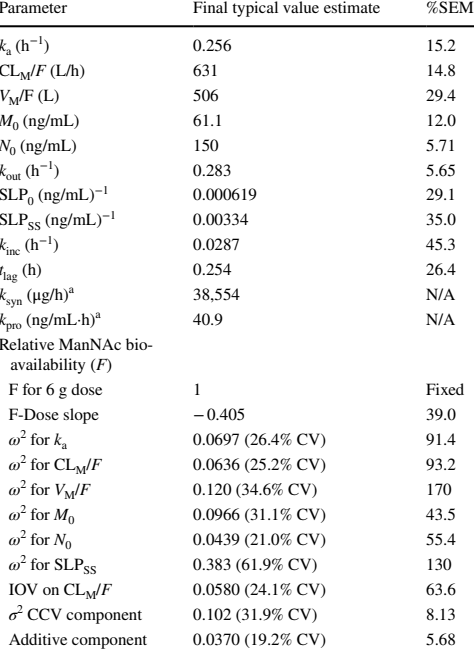

Unnamed: 0 Channels system  n Itrans (kJ/mol) Idisp (kJ/mol)  Idisp /Itrans
0         BEA    12 × 12 × 12  3            −148           −129           0.87
1         BEC    12 × 12 × 12  1            −123           −151           1.22
2         BOG    12 × 10 × 10  4            −140           −140           1.00
3         CON    12 × 10 × 10  2            −132           −149           1.14
4         FAU    12 × 12 × 12  7            −104           −106           1.02
5         ITT    18 × 10 × 10  4            −110           −155           1.41
6         IWR    12 × 10 × 10  1            −145           −174           1.20
7         IWV         12 × 12  2            −102            −90           0.88
8         MOR          12 × 8  2            −141           −104           0.74
9         SEW         12 × 10  2            −160           −188           1.18
10        USI         12 × 10  2            −128           −157           1.22
11        UTL         14 × 12  2            −105           −137           1.31

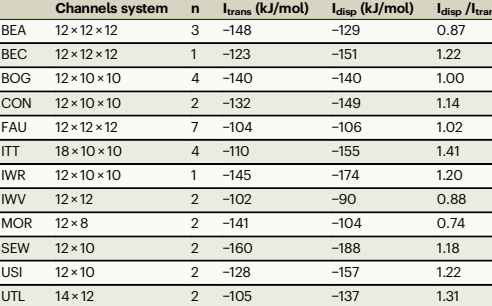

Unnamed: 0 Channels system    Ea1   Ea2   Ea3   Ea4   Ea5    Ea6  \
0      transalkylation                                                         
1                  BEC    12 × 12 × 12   98.0  35.0  44.0  48.0  85.0   98.0   
2                  BOG    12 × 10 × 10   75.0  29.0  65.0  50.0  88.0   96.0   
3                  IWR    12 × 10 × 10   71.0  31.0  60.0  44.0  91.0   90.0   
4                  IWV         12 × 12   56.0  21.0  52.0  47.0  60.0   86.0   
5                  MOR          12 × 8   95.0  33.0  78.0  50.0  84.0   87.0   
6             UTL(int)         14 × 12   59.0  29.0  49.0  49.0  82.0   97.0   
7             UTL(cha)         14 × 12   64.0  28.0  57.0  45.0  68.0   80.0   
8   disproportionation                                                         
9                  BEC    12 × 12 × 12  113.0  30.0  56.0  55.0  78.0  118.0   
10                 IWV         12 × 12   72.0  30.0  75.0  59.0  67.0  104.0   
11            UTL(int)         14 × 12   90.0  29.0  69.0  58.0  71.0   98.0   
12            UTL(cha)         14 × 12   80.0  22.0  73.0  46.0  82.0   97.0   

    is_spanning_row  
0              True  
1             False  
2             False  
3             False  
4             False  
5             False  
6             False  
7             False  
8             False  
9             False  
10            False  
11            False  
12            False

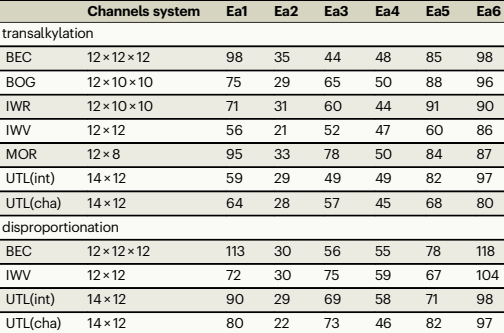

zeolite IZA code  DEB conv. (%)  rtrans (molEB/molacidh)  EB (%)  \
0     ITQ-33      ITT           11.9                      717    76.4   
1     ITQ-15      UTL           17.7                     1599    85.7   
2        USY      FAU           14.7                     1075    90.1   
3     ITQ-17      BEC           20.8                      628    88.8   
4     ITQ-27      IWV           14.9                     1926    94.1   
5     ITQ-24      IWR           15.2                      676    95.1   
6     ITQ-47      BOG           14.4                      349    90.4   
7  mordenite      MOR            9.6                      279    88.6   

   TEB (%)  C2H4 (%)  HP (%)  Eaa (kJ/mol)  
0     20.8       0.6     2.1          75.2  
1     12.0       0.0     2.3          56.1  
2      2.7       2.7     4.5          66.5  
3      8.3       0.5     2.3          59.5  
4      0.5       2.3     3.0          58.3  
5      2.5       0.4     2.0          69.4  
6      4.4       4.8     0.4          66.2  
7      2.5       4.6     4.2          74.2

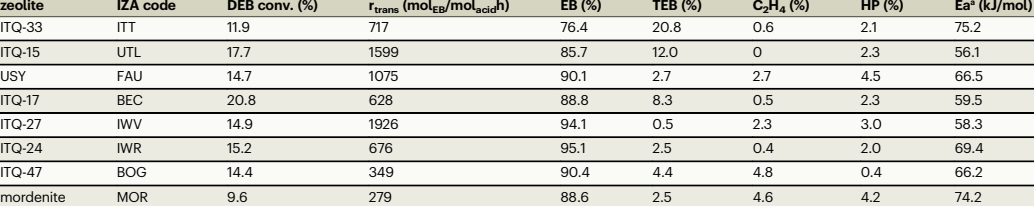

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 1, Unnamed: 2, Unnamed: 3, Unnamed: 4, Unnamed: 5, Unnamed: 6]
Index: []

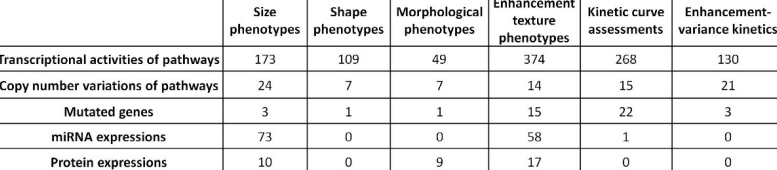

Data Platform         Unnamed: 1 Number of Features  \
0     Number of features and tumors  in different data          platforms   
1                         Radiomics                                    38   
2                  Gene expressions              20531         genes (186   
3            Copy number variations              19950         genes (186   
4                 miRNA expressions                                  1046   
5               Protein expressions                                   142   
6                     Mutated genes                                  3734   
7                                                                           
8   Number of tumors with different       pathological             stages   
9                                                                           
10                                                                          
11               Pathological Stage                  T                  M   
12                                0                                    91   
13                                I                 38                      
14                               II                 50                      
15                              III                  3                      
16                                X                                         
17                                                                          
18  Number of tumors with different          molecular  receptor statuses   
19                  Receptor Status                 ER                      
20                         Negative                 14                      
21                         Positive                 77                      

   Unnamed: 3 Number of tumors  is_spanning_row  
0                                         False  
1                           91            False  
2   pathways)               91            False  
3   pathways)               91            False  
4                           91            False  
5                           62            False  
6                           91            False  
7                                          True  
8                                          True  
9                                         False  
10                                         True  
11          N          Overall            False  
12         46                             False  
13         34               22            False  
14          6               58            False  
15          4               11            False  
16          1                             False  
17                                         True  
18                                         True  
19         PR             HER2            False  
20         19               72            False  
21         72               19            False

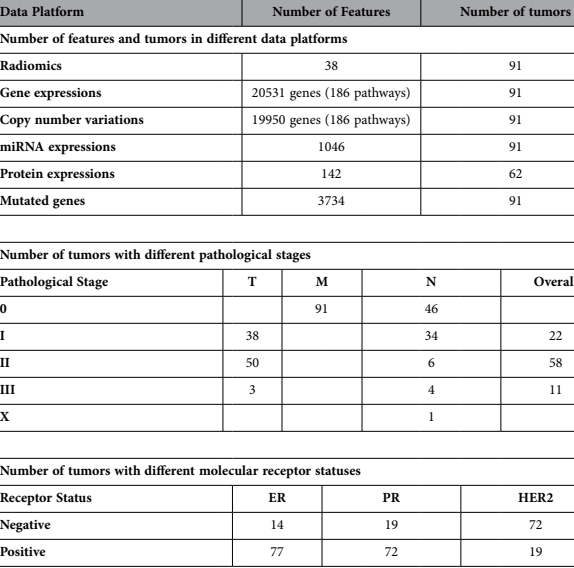

Unnamed: 0       SF-ROXOX      SF-ROXNIT  \
0                 No. of crystals             75             62   
1                Images collected           1867           1257   
2   Images merged Data collection           1377           1039   
3                     Space group           P213           P213   
4                 a = b = c (A˚ )          94.95          94.92   
5                   =  =  ( )             90             90   
6                Resolution (A˚ )     54.82–1.50     54.80–1.50   
7                                    (1.54–1.50)    (1.54–1.50)   
8                     Rsplit† (%)    11.5 (90.4)    10.6 (85.3)   
9                                                                 
10                       hI/(I)i      6.3 (2.0)      6.6 (2.3)   
11                         CC1/2‡  0.980 (0.157)  0.984 (0.288)   
12                                                                
13               Completeness (%)  100.0 (100.0)  100.0 (100.0)   
14                                                                
15                   Multiplicity   220.9 (77.2)   154.7 (50.8)   
16                              2                                 
17          Wilson B factor (A˚ )           14.9           14.5   
18                                                                
19                     Refinement                                 
20                                                                
21                                                                
22      No. of unique reflections   45883 (2276)   45846 (2275)   
23                                                                
24                Rwork/Rfree (%)      14.4/17.7      14.3/17.1   
25                   No. of atoms                                 
26                        Protein           2608           2595   
27                     Ligand/ion             37             34   
28                          Water            425            418   
29                B factors (A˚ 2                                 
30                              )                                 
31                                                                
32                        Protein           18.9           18.7   
33                             Cu           16.5           16.2   
34                          SO4 2           33.2           41.5   
35                       NO2 18.5                                 
36                       Malonate                          37.2   
37                          Water           30.0           30.0   
38              R.m.s. deviations                                 
39             Bond lengths (A˚ )          0.013          0.013   
40                Bond angles ()          1.612          1.594   
41                       PDB code           6gsq           6gt0   

        SF-ROXRED  is_spanning_row  
0              33            False  
1             581            False  
2             410            False  
3            P213            False  
4           94.61            False  
5              90            False  
6      54.62–1.60            False  
7     (1.64–1.60)            False  
8     15.8 (70.8)            False  
9                            False  
10      5.4 (2.7)            False  
11  0.957 (0.384)            False  
12                           False  
13  100.0 (100.0)            False  
14                           False  
15    66.1 (44.3)            False  
16                           False  
17           17.5            False  
18                           False  
19                           False  
20                            True  
21                           False  
22   37489 (1858)            False  
23                           False  
24      16.7/19.9            False  
25                            True  
26           2580            False  
27             59            False  
28            279            False  
29                           Fa

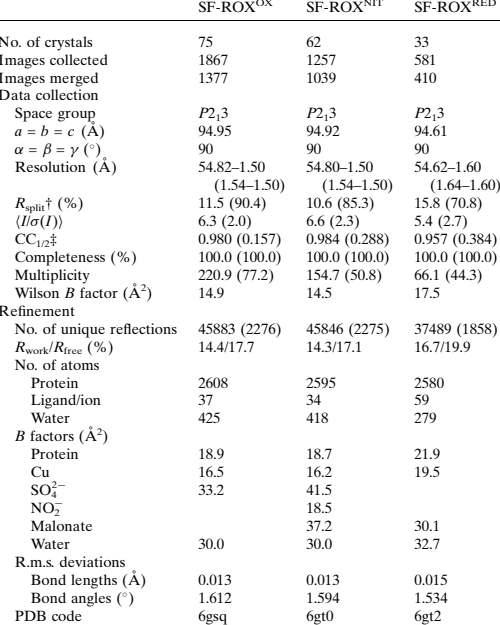

Unnamed: 0           Unnamed: 1  is_spanning_row
0             Data collection                                 False
1      Wavelength range (A˚ )            3.05–4.00            False
2               No. of images                   20            False
3         Setting spacing ()                    7            False
4   Average exposure time (h)                   18            False
5                 Space group                 P213            False
6             a = b = c (A˚ )                97.98            False
7               =  =  ( )                   90            False
8            Resolution (A˚ )  40–1.80 (1.90–1.80)            False
9                 Rp.i.m. (%)           6.3 (12.7)            False
10                   hI/(I)i            7.9 (3.7)            False
11           Completeness (%)          85.5 (69.8)            False
12               Multiplicity            6.5 (2.9)            False
13                                                             True
14                                                            False
15                 Refinement                                  True
16  No. of unique reflections                24728            False
17            Rwork/Rfree (%)          23.17/27.64            False
18               No. of atoms                                  True
19                                                             True
20                      Total                 5659            False
21                    Protein                 5109            False
22                         Cu                    2            False
23                        D2O  182 D2O [546 atoms]            False
24                          O                    2            False
25          B factors (A˚ 2 )                                  True
26                    Protein                 15.2            False
27                         Cu                  8.6            False
28                      Water                 20.2            False
29          R.m.s. deviations                                  True
30         Bond lengths (A˚ )                0.004            False
31            Bond angles ()                0.884            False
32                   PDB code                 6gtj            False

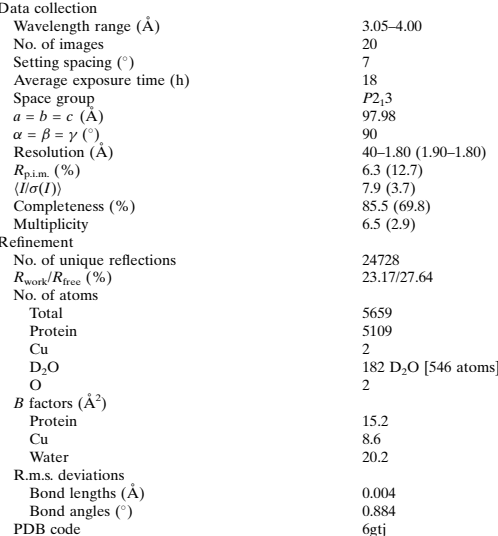

Year  Variety  Treatment Spikelets per panicle 1000-grain weight (g)  \
0   2019     CJ03         T0               267.67a                21.87c   
1                         T1                91.17b                20.10d   
2           W1844         T0               275.67a                22.91b   
3                         T1                97.92b                25.95a   
4   2020     CJ03         T0               259.75a                22.38c   
5                         T1                77.50c                20.97d   
6           W1844         T0               273.67a                24.35b   
7                         T1                92.58b                25.19a   
8   Year  Variety  Treatment        SG per panicle        IG per panicle   
9   2019     CJ03         T0               104.65a               163.02b   
10                        T1                31.04c                60.13d   
11          W1844         T0                68.31b               207.36a   
12                        T1                24.15d                73.77c   
13  2020     CJ03         T0                80.83a               178.92b   
14                        T1                23.25c                54.25d   
15          W1844         T0                67.33b               206.34a   
16                        T1                22.42c                70.16c   

   Seed setting rate (%)   Unnamed: 6  
0                 87.67c               
1                 93.00b               
2                 84.92d               
3                 95.58a               
4                 92.25b               
5                 94.17a               
6                 85.17c               
7                 94.67a               
8            SG rate (%)  IG rate (%)  
9                 39.10a       60.90b  
10                34.05a       65.95b  
11                24.78b       75.22a  
12                24.67b       75.33a  
13                31.12a       68.88b  
14                30.00a       70.00b  
15                24.60b       75.40a  
16                24.21b       75.79a

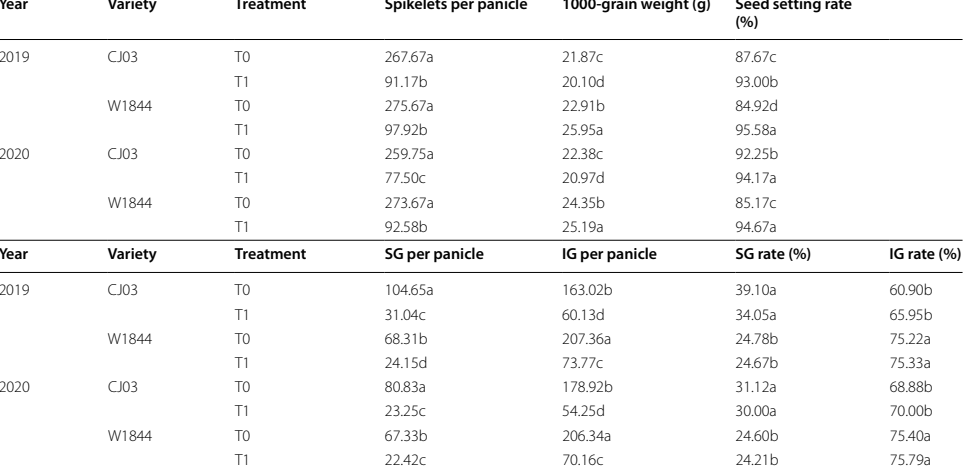

Year Variety Treatment Net photosynthetic rate (umol·m−2 s−1 )  \
0  2019.0    CJ03        T0                                  22.51a   
1                        T1                                  20.06c   
2           W1844        T0                                  21.91a   
3                        T1                                  20.72b   
4  2020.0    CJ03        T0                                  25.40a   
5                        T1                                  20.92c   
6           W1844        T0                                  24.91a   
7                        T1                                  21.92b   

  Stomatal conductance (mmol·m−2 s−1 )  \
0                                0.65b   
1                                0.52c   
2                                0.74a   
3                               0.60bc   
4                                0.86a   
5                                0.54c   
6                                0.89a   
7                                0.75b   

  Intercellular CO2 concentration (μmol·mol−1 ) Trmmol rate (mmol·m−2 s−1 )  
0                                       285.30b                       6.53a  
1                                       268.55c                       5.32c  
2                                       305.32a                       6.28a  
3                                       274.15b                       5.68b  
4                                      225.50ab                      13.73a  
5                                       210.57c                      11.72c  
6                                       233.63a                      13.78a  
7                                       220.72b                      12.71b

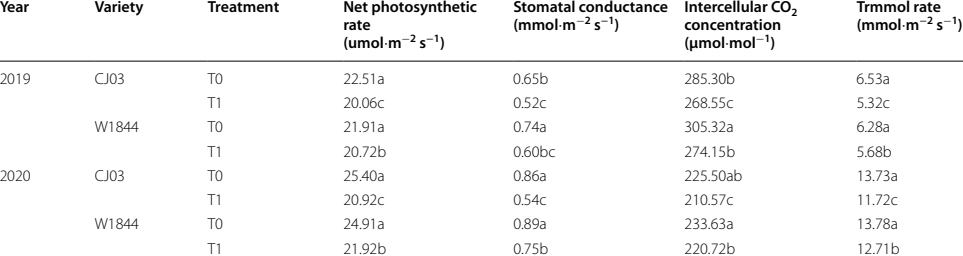

IS                    Inferior spikelets  \
0           SS                   Superior spiklelets   
1    OsSWEET11               Oryza sativa Sugar will   
2       OsSUTs                  Oryza sativa Sucrose   
3          SPS                     Sucrose-phosphate   
4       SuSase                      Sucrose synthase   
5       AGPase                           ADP-glucose   
6          T6P                 Trehalose-6-phosphate   
7        SnRK1                  Snf1-related protein   
8          TPS                 Trehalose-6-phosphate   
9          TPP                 Trehalsoe-6-phosphate   
10         ABA                         Abscisic acid   
11         CKs                            Cytokinins   
12          ZT                                Zeatin   
13         IAA                                 Auxin   
14          SG                    Superior spikelets   
15          IG                    Inferior spikelets   
16         DPA                    Days post anthesis   
17  HPLC–MS/MS  High-performance liquid spectrometry   
18       ANOVA                  Analysis of variance   

                            Unnamed: 2 Unnamed: 3  
0                                                  
1   eventually be exported transporter         11  
2                         transporters             
3                             synthase             
4                                                  
5                    pyrophosphorylase             
6                                                  
7                             kinase-1             
8                             synthase             
9                          phosphatase             
10                                                 
11                                                 
12                                                 
13                                                 
14                                                 
15                                                 
16                                                 
17               chromatography–tandem       mass  
18

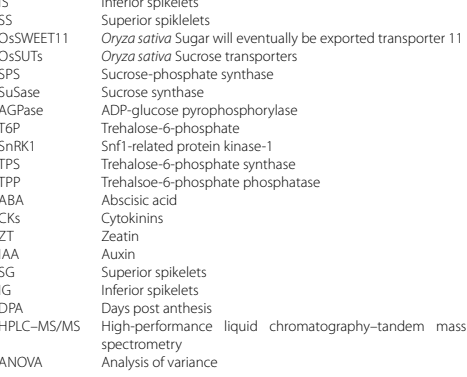

Patient no Genotype Viral load (106 IU/ml) Sex Age (years) Core 70  \
0          R1       1a                   4.36   M        52.6       R   
1          R2       1a                   6.37   M        34.9       R   
2          R3       1a                   7.84   M        45.8       R   
3          R4       1a                   7.77   F        42.3       R   
4          R5       1a                   7.05   M        45.3       R   
5          R6       1a                   7.19   F        45.5       R   
6          R7       1a                   5.54   F        46.9       R   
7          R8       1a                   5.46   M        29.1       R   
8          R9       1a                   6.18   M        50.7       R   
9         R10       1a                   6.42   M        59.9       R   
10        R11       1a                   5.85   M        46.4       R   
11        R12       1a                   7.25   M        36.4       R   
12        R13       1a                   6.43   M        57.5       R   
13        R14       1a                   6.06   M        39.2       R   
14        R15       1a                   6.63   F        47.1       R   
15        R21       1a                   5.36   F        29.6       R   
16        R22       1a                   5.55   F        28.7       R   
17        R23       1a                   6.43   F        41.2       R   
18        R24       1a                    6.1   M        51.3       R   
19        R25       1a                   7.49   F        55.7       R   
20        R28       1a                   7.79   M        41.5       R   
21         N1       1a                   6.28   M        40.5       R   
22         N2       1a                   6.25   M        50.3       R   
23         N3       1a                    6.1   M        55.9       R   
24         N4       1a                   7.05   M        47.9       R   
25         N5       1a                   5.89   M        50.8       R   
26         N6                            6.42   F        48.1       P   
27                  1a                                                  
28         N7       1a                   6.72   M        48.9       R   
29         N8       1a                   7.35   M        54.6       R   
30         N9       1a                   6.13   F        57.8       R   
31        N10       1a                   6.72   M        54.6       R   
32        N11       1a                   6.42   M        48.0       R   
33        N12       1a                   7.32   F        48.4       R   
34                                              M                   R   
35        N13       1a                   6.09            24.3           
36        N14       1a                   6.31   M        35.0       R   
37        N20       1a                   6.73   F        35.0       R   
38        N21       1a                   7.15   F        45.0       R   
39        R16       1b                   4.13   F        46.5       R   
40        R17       1b                   4.94   M        31.5       R   
41        R18       1b                    5.4   F        58.7       R   
42                  1b                                                  
43        R19                            6.23   F        38.4       R   
44        R20       1b                   7.39   F        47.8       R   
45        R26       1b                   7.17   M        46.6       R   
46        R27       1b                   6.81   M        56.8       R   
47        R29       1b                   7.55   M        57.0       Q   
48        N15       1b                   6.08   F        56.5       Q   
49        N16       1b                   6.57   F        58.5       Q   
50        N17       1b                   7.37   M        48.9       Q   
51        N18       1b                   6.69   M        62.8       Q   
52        N19       1b                    6.7   F        54.2       Q   

   amino acid 91 rs12979860 End of treatment response a  
0 

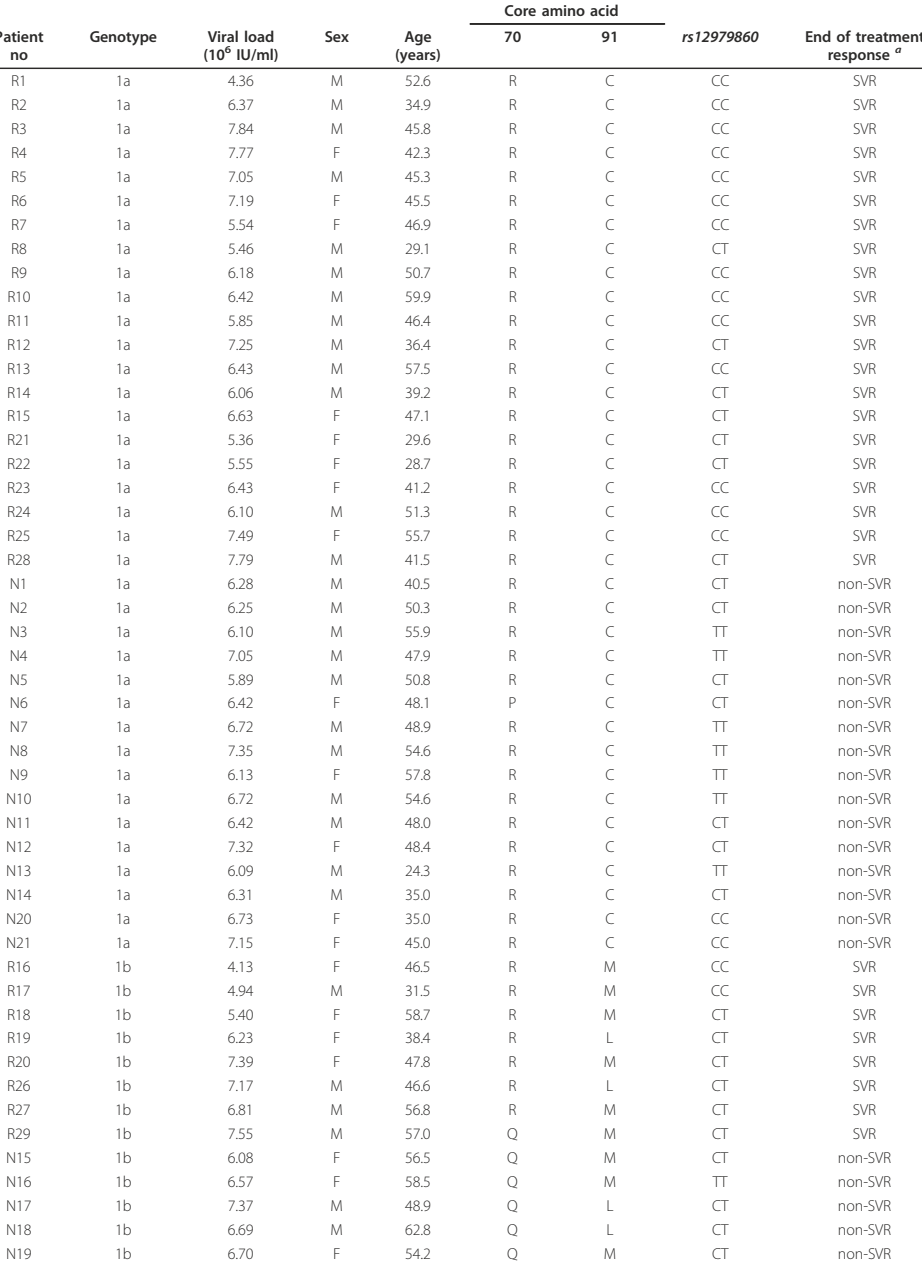

Unnamed: 0            SVR n = 29  \
0                           Age (mean)                  45.2   
1   Number of patients < 45 / > 45 yrs               11 / 18   
2                         Gender (m/f)               17 / 12   
3    Baseline HCV RNA (mean log IU/mL)                  6.37   
4  Number with < 5.6 / > 5.6 log IU/mL                8 / 21   
5                       Genotype 1a/1b                21 / 8   
6           Fibrosis (F0/F1/F2/F3/F4)c   0 / 10 / 13 / 4 / 0   
7                           Core aa 70            28 R / 1 Q   
8                           Core aa 91      21 C / 6 M / 2 L   
9                           rs12979860  16 CC / 13 CT / 0 TT   

        non-SVR n = 21 Univariate p value  
0                 48.8              0.09a  
1               4 / 17              0.21b  
2               13 / 8               1.0b  
3                 6.59              0.56a  
4               0 / 21              0.01b  
5               16 / 5               1.0b  
6    2 / 4 / 4 / 7 / 2              0.19d  
7     15 R / 5 Q & 1 P              0.03b  
8     16 C / 3 M / 2 L              0.82e  
9  2 CC / 11 CT / 8 TT            0.0001e

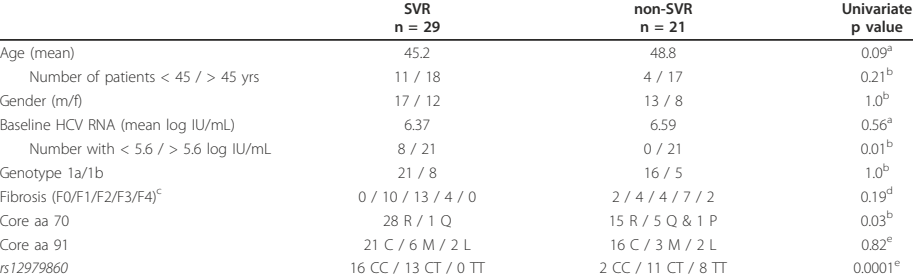

Genotype    Q Amino R acid 70 P    H Amino C acid M  91 L  Total
0       1a   2%     98%         -    -    100%      -     -    920
1       1b  60%     35%         -   4%      1%    71%   28%   2022
2        2    -    100%         -    -     39%     4%   58%     83
3        3    -     93%        6%    -     99%      -     -    204
4        4   5%     95%         -    -    100%      -     -     19
5        5  86%     14%         -    -       -      -  100%     14
6        6  60%     13%       13%  15%    100%      -     -     55

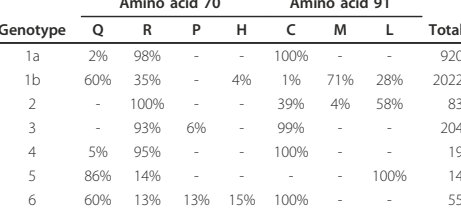

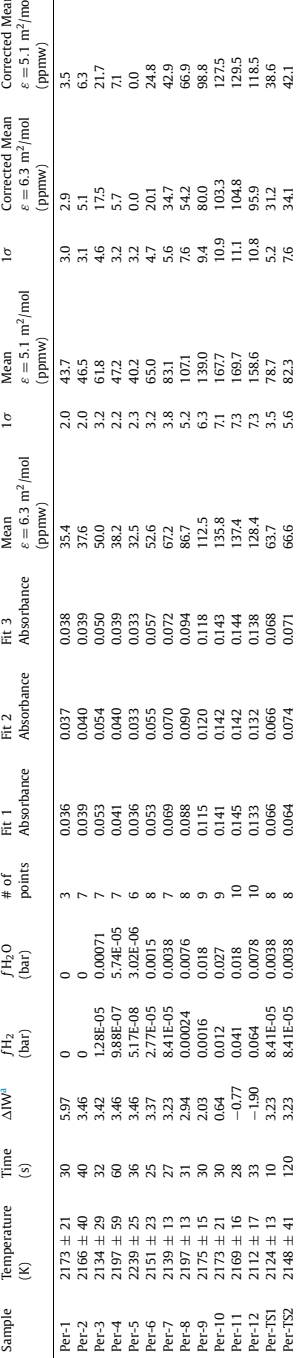

This work (ε3550 6.3 m2/mol)                   Peridotite     (K) 2173  \
0  This work (ε3550 = 5.1 m2/mol)                   Peridotite         2173   
1          Newcombe et al. (2017)  Anorthite-Diopside eutectic         1623   
2          Newcombe et al. (2017)            Lunar Green Glass         1623   
3             Dixon et al. (1995)       Mid-Ocean Ridge Basalt         1473   
4      Hamilton and Oxtoby (1986)                    NaAlSi3O8  1123 – 1573   

  Unnamed: 3        (bar−0.5) 2.91 10−3 (bar) 5.7 10−5 0.027  14  
0                           3.59 × 10−3   5.7 × 10−5 – 0.027  14  
1                           4.22 × 10−3    9.8 × 10−3 – 0.32  14  
2                           4.04 × 10−3    9.8 × 10−3 – 0.32  11  
3                           5.36 × 10−3             17 – 709  14  
4             7.59 × 10−3 – 9.91 × 10−3          1685 – 2160  13

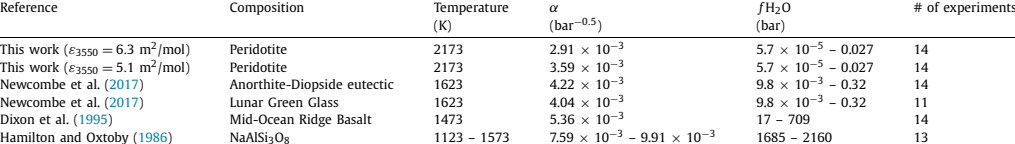

In [ ]:
from IPython.display import Image, display
import pandas as pd
for subdir in sorted(os.listdir("results")):
    for filename in sorted(os.listdir(f"results/{subdir}")):
        if filename.endswith(".png"):
            display(Image(f"results/{subdir}/{filename}"))
        elif filename.endswith(".csv"):
            df = pd.read_csv(f"results/{subdir}/{filename}")
            df.fillna("",inplace=True)
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                display(df)

Strengths:
- alignment accuracy
- small and medium size tables
- throughput

Weaknesses:
- rotated/vertical tables (future support)
- multi-indexes
- underlying OCR issues
- uneven columns, as in 4.pdf